## Introdução a NLP

Processamento de Linguagem Natural (NLP)

Dados textuais estão em toda parte e você, como empresa ou alguém que esteja trabalhando para lançar um novo produto, pode utilizá-los para validar, melhorar e expandir esses produtos. A ciência que extrai significado e aprendizado de dados textuais disponíveis no mundo é chamada de Processamento de Linguagem Natural (NLP).

Este guia irá auxiliar na construção de soluções que envolvem Aprendizado de Máquina (ML). Além disso, depois de acompanhar estas orientações, será possível:

- Coletar, preparar e inspecionar dados;
- Construir modelos preditivos simples;
- Interpretar e entender seus modelos, certificando-se de que ele está aprendendo informações relevantes e não ruído

### Coletando dados

Todo problema em ML começa com dados, como uma lista de e-mails, postagens em redes sociais ou chats. 

O conjunto de dados utilizado neste guia é chamado de “Disasters on Social Media” e possui mais de 10.000 tweets que foram selecionados a partir de buscas envolvendo chaves como “em chamas”, “quarentena” e “pandemônio”, relacionando posteriormente o resultado dessas buscas com eventos realmente desastrosos e não desastrosos. A tarefa a ser realizada nestes dados, é identificar um tweet realmente relevante em relação a um desastre. Uma aplicação para a solução que será desenvolvida aqui, em potencial, seria avisar aos bombeiros sobre um desastre que realmente está acontecendo de rapidamente. No entanto, realizar este procedimento contornando uma publicação referente a um filme de ação, por exemplo, que pode conter as mesmas palavras chaves relacionadas com um desatre.A seguir a importação das bibliotecas úteis para o desenvolvimento do guia.

In [1]:
# importando bibliotecas
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import gensim
import warnings
import seaborn as sns
warnings.filterwarnings(action='once')

2022-05-14 21:47:20.728289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 21:47:20.728320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# inspecionando os dados 
url = 'https://raw.githubusercontent.com/hundredblocks/concrete_NLP_tutorial/master/socialmedia_relevant_cols.csv'
data = pd.read_csv(url, encoding='ISO-8859-1')
data.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [3]:
data.dtypes

text           object
choose_one     object
class_label     int64
dtype: object

In [4]:
data.choose_one.value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

### Limpando os dados

O primeiro passo é saber examinar os dados para, posteriormente, limpá-los. Um conjunto de dados limpo permitirá que um modelo aprenda apenas recursos significativamente relevantes e não se adeque a ruídos. Ruídos são características do texto que não são significativos para caracterizar o que se pretende avaliar. No exemplo dos tweets, a hashtag (#) usada para compor determinadas palavras em nada caracteriza o texto propriamente dito. Outras características  que precisam ser consideradas na limpeza dos dados são:

- Remover caracteres irrelevantes como os não alfanuméricos;
- Remover palavras que não são relevantes, como as menções indicadas com “@”;
- Converter termos para minúsculos, homogeneizando os dados (OLÁ – olá);
- Combinar palavras escritas incorretamente para uma única representação (legaaalll – legal);
- Considerar lematização (reduzir palavras como “sou”, “é” para uma forma desflexionada como “ser”);
- Quebrar o seu texto em termos.

Após considerar as opções de limpeza acima, é possível começar a usar os dados para treinar um modelo de predição.

In [5]:
# expressões regulares para limpeza dos dados

def standardize_text(data, text_field):
    df = data.copy()
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [6]:
clean_data = standardize_text(data, "text") 
clean_data.to_csv("socialmedia_relevant_cols_clean.csv")
clean_data.head(5)

/tmp/ipykernel_10256/2697883949.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")


,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,heard about earthquake is different cities s...,Relevant,1
3,there is a forest fire at spot pond geese are...,Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [7]:
# exemplo antes
data.text.iloc[468]

'@AberdeenFC @AberdeenFanPage \r\n\r\nGood luck to the ?????? tomorrow night \r\n\r\nGet some coefficient points plz \r\n@Armageddon????'

In [8]:
# exemplo depois
clean_data.text.iloc[468]

'      good luck to the        tomorrow night     get some coefficient points plz   '

### Quebrando os dados

Agora que temos os dados limpos, vamos transformá-los para que o modelo possa entender. Logo:

- Quebrar as sentenças em listas de palavras separadas;
- Dividir os dados para treinamento e teste do modelo;
- Inspecionar os dados novamente

In [9]:
# método de quebra dos dados 
from nltk.tokenize import RegexpTokenizer 

tokenizer = RegexpTokenizer(r'\w+') 
clean_data["tokens"] = clean_data["text"].apply(tokenizer.tokenize)

In [10]:
clean_data.sample(3)

,text,choose_one,class_label,tokens
1813,i hope the only time i end up on tv is when i ...,Relevant,1,"[i, hope, the, only, time, i, end, up, on, tv,..."
10462,in europe nature is kind while in us they have...,Relevant,1,"[in, europe, nature, is, kind, while, in, us, ..."
4916,the fact checking machine must have exploded t...,Not Relevant,0,"[the, fact, checking, machine, must, have, exp..."


In [11]:
all_words = [word for tokens in clean_data["tokens"] for word in tokens] 
sentence_lengths = [len(tokens) for tokens in clean_data["tokens"]] 
vocab = sorted(list(set(all_words))) 
print("Quantidade total de palavras: %s \nVocabulario: %s" %(len(all_words), len(vocab)))
print("Tamanho máximo de uma sentença: %s" %max(sentence_lengths))

Quantidade total de palavras: 154199 
Vocabulario: 18072
Tamanho máximo de uma sentença: 34


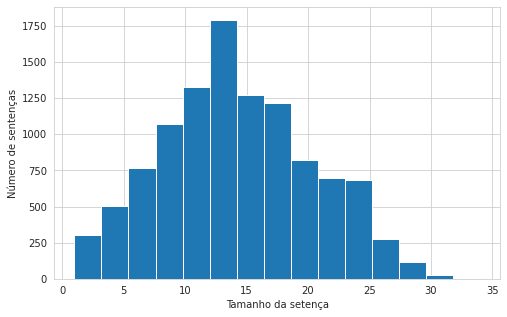

In [12]:
# distribuilção das sentenças por quantidade de palavras 
sns.set_style("whitegrid")
fig = plt.figure(figsize=(8, 5)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths, bins = 15) 
plt.show()

Podemos observar que a distribuição no tamanho das sentenças tende a normalidade. Essa característica é importante para evitar viés no processo de classificação quanto ao tamanho dos textos avaliados e a quantidade de palavras específicas em uma determinada sentença.

### Processamento de Linguagem Natural e Aprendizado de Máquina

Agora que nossos dados foram lidos e preparados, vamos mergulhar na parte de Machine Learning e NLP. No Processamento de Linguagem Natural, precisamos de dados de entrada para realizar as previsões e, esses dados, são as representações textuais do que se pretende avaliar.

No caso deste guia, iremos utilizar as frases (tweets) que foram coletados nos passos anteriores para realizar as predições.

A abordagem mais simples que podemos utilizar é o modelo de mala de palavras ou, como é mais conhecido: bag-of-words. Uma mala de palavras é uma matriz contento uma variação entre 0 e 1 para representar a siginificância de uma palavra em uma determinada setença, em sua abordagem mais simplificada. Neste guia, usaremos duas abordagens para construção de malas de palavras: Count vectorizer e TF-IDF vectorizer.

### Count Vectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 

# separando o texto da variável alvo 
list_corpus = clean_data["text"].tolist() 
list_labels = clean_data["class_label"].tolist() 

# construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)     

# aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 

# contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

### Visualizando o Vocabulário

Agora que já criamos o vocabulário para treinar o modelo, vamos tentar identificar algum tipo de estrutura semelhante ou agrupamento baseado na variável alvo. No mundo real perfeito, nosso vocabulário seria tão distinto considerando a variável alvo, que estariam distribuidos perfeitamente em grupos separados. A projeção será feita em duas dimensões (LSA).

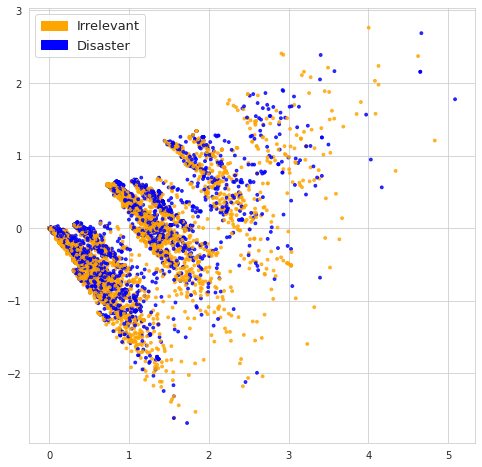

In [14]:
from sklearn.decomposition import PCA, TruncatedSVD

# método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_PCA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)        
        lsa.fit(test_data)        
        lsa_scores = lsa.transform(test_data)        
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}        
        color_column = [color_mapper[label] for label in test_labels]        
        colors = ['orange','blue','blue']        
        if plot:            
           plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
           red_patch = mpatches.Patch(color='orange', label='Irrelevant')            
           green_patch = mpatches.Patch(color='blue', label='Disaster')           
           plt.legend(handles=[red_patch, green_patch], prop={'size': 13})            

fig = plt.figure(figsize=(8, 8))          
plot_PCA(X_train_counts, y_train)
plt.show()

Nosso vocabulário não parece muito bem separado em grupos distintos de palavras que explicam a variável alvo. No entanto, vamos ver se é possível construir um modelo útil para lidar com ele no tutorial de NLP e M

### Treinando o Classificador

Vamos iniciar com uma **regressão logística**, visto que, é simples, e muitas vezes resolve o problema.

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf.fit(X_train_counts, y_train) 
y_predicted_counts = clf.predict(X_test_counts)

### Avaliando o Classificador

Agora vamos obervar e avaliar algumas métricas para identificar se nosso classificador apresentou um bom desempenho. Para isso, usaremos métricas comumente utilizadas para avaliação de preditores (acurácia, precisão, cobertura e F1-score).

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 

def get_metrics(y_test, y_predicted):      
   precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')*100                 
   recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')*100        
   f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')*100         
   accuracy = accuracy_score(y_test, y_predicted)*100  

   return accuracy, precision, recall, f1 

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("Accuracy = %.2f%%\nPrecision = %.2f%%\nRecall = %.2f%%\nF1 = %.2f%%" % (accuracy, precision, recall, f1))

Accuracy = 77.34%
Precision = 77.16%
Recall = 77.34%
F1 = 77.21%


Um classificador muito bom apresentaria métricas próximas de 1. Logo, para que se aproxime de 1 ou seja exatamente 1, a quantidade de falsos-positivos e falsos-negativos deve ser 0. Avaliando as métricas que extraímos, podemos observar que estamos longe disso.

Para analisar especificamente os erros, usaremos outra abordagem bastante conhecido no meio: a matriz de confusão.

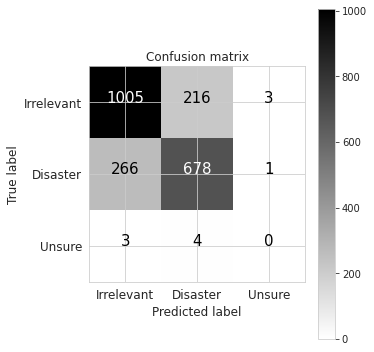

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="black" if cm[i, j] < thresh else "white", fontsize=15)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()

Como podemos obervar, nosso classificador, para alguns casos, classifica como incerteza algumas das classes que está tentando predizer. Para nós, isso é pouco relevante.

O que mais chama a atenção é ele apontar mais falsos-negativos (textos que remetiam a desastres classificados como não desastrosos) do que falsos-positivos (textos que remetiam a eventos não desastrosos classificados como desastrosos). Dependendo do caso de uso, isso pode ser aceitável. No entanto, pensando no caso de aplicação para avisar os bombeiros, errar qualquer uma das predições pode gerar uma perda grande para a aplicação real da solução.

Vamos realizar uma inspeção adicional para entender quais features (palavras) estão sendo usadas pelo classificador para tomada de decisão.

In [18]:
# método para identificação das features mais importantes na tomada de decisão. 

def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        

    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom} 
        
    return classes 
importance = get_most_important_features(count_vectorizer, clf, 10)

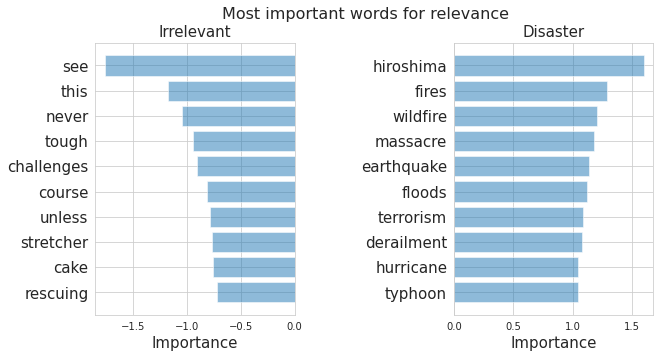

In [19]:
# método para plotar as featrues mais importantes para cada variável alvo. 

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 5))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=15)
    plt.yticks(y_pos, bottom_words, fontsize=15)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=15)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=15)
    plt.yticks(y_pos, top_words, fontsize=15)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=15)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Podemos observar que nosso classificador capta alguns padrões realmente relevantes e relacionados com desastres e não desastres (ex. hiroshima e descarrilhamento). No entanto, parece estar aprendendo termos irrelevantes para discriminar os fatos. Esses termos são tratados como ruídos e, quando se aprende ruídos, identificamos o que chamamos de overfitting (super ajuste do modelo).

###  TF-IDF Bag of Words

Nesta seção vamos trabalhar com uma abordagem para construção da mala de palavras (bag-of-words) de uma forma mais refinada. Nós iremos usar agora a abordagem TF-IDF (Term Frequency, Inverse Document Frequency), essa abordagem não realiza apenas a contabilização dos termos, unicamente, pela quantidade de vezes em que ele aparece, mas também leva em consideração em quantos textos ele aparece individualmente.

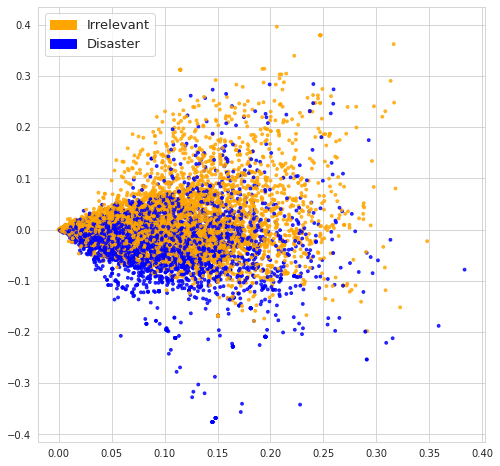

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=False)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(8, 8))          
plot_PCA(X_train_tfidf, y_train)
plt.show()

Obervando o gráfico acima, podemos perceber que a nova abordagem agrupou os dados melhor que a abordagem anterior. Vamos ver se isso impacta na capacidade de predição do classificador?

In [21]:
clf_tfidf = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [22]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("Accuracy = %.2f%%\nPrecision = %.2f%%\nRecall = %.2f%%\nF1 = %.2f%%" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

Accuracy = 78.49%
Precision = 78.18%
Recall = 78.49%
F1 = 78.31%


/home/isabel/Música/computacao-cognitiva/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comparando os novos resultados obtidos, por meio da abordagem para contagem de termos TF-IDF, podemos obervar que obtivemos uma pequena melhora na capacidade de predição do modelo.
Vamos analisar a matriz de confusão e entender como os erros estão acontecendo.

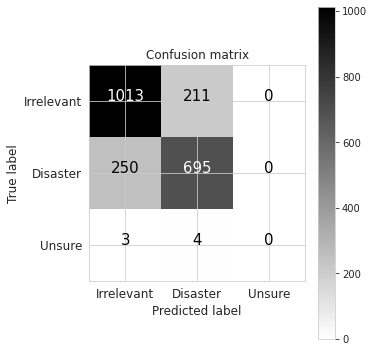

In [23]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 
fig = plt.figure(figsize=(5, 5)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 

Podemos observar que tivemos uma redução na quantidade de falsos-positivos e falsos-negativos. Vamos obervar quais palavras foram consideradas mais importantes para tomada de decisão do novo classificador.

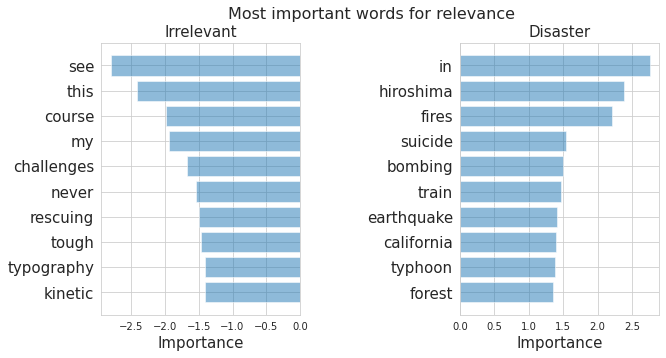

In [24]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Vemos que a ordem de relevância das palavras mudou bastante e que muitas palavras pouco relevantes para identificar os fatos foram descartadas. Sendo assim, podemos ter mais confiança nos resultados que obtivemos aqui e, também, que realmente obtivemos uma melhora em relação ao processo anterior, embora não tenha sido muito grande.

### Conclusões

Os dois primeiros modelos captam palavras de alta relevância. No entanto, é improvável que qualquer problema de NLP e ML apresente um conjunto de treinamento com todas as palavras realmente relevantes. Para resolver esse problema, é possível capturar o significado semântico das palavras. Ou seja, precisamos entender o grau de relação semântica que as palavras "bom"/"postivo" e "cereja"/"continente" apresentam entre si, por exemplo.

Neste notebook, trabalhei com algumas técnicas comuns de NLP em Python, a saber:

- Pré-processamento de texto básico
- Um simples modelo de incorporação de palavras
- TF-IDF + mala de palavras

Estas são técnicas básicas - é importante notar que todas elas são relativamente rudimentares no contexto das complexidades da linguagem natural. Fundamentalmente, os embeddings que usamos realmente não incorporam muita informação contextual e não incluem memória, ambas fundamentais para a linguagem. Há muito trabalho atual para usar o aprendizado profundo para NLP e modelos de última geração incorporam vários graus de contextualização e memória.